## GAN - faces generation

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
from PIL import Image
import random
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)

In [2]:
!pip install torch-summary
from torchsummary import summary

## Prepare data

In [5]:
def get_dataloader(image_size, batch_size, path): #func Dataloader
    transforms = tt.Compose([
        tt.Resize(image_size),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    images = ImageFolder(path, transform=transforms)
    return DataLoader(images, batch_size=batch_size, shuffle=True)

In [6]:
path = '/kaggle/input/'
image_size = 128
batch_size = 32

loader = get_dataloader(image_size, batch_size, path) #create Dataloader

In [6]:
def show_example_images(amount_images, images): #show some pics
    images = images.detach().numpy()
    random_image = [np.random.randint(0, len(images)-1) for pic in range(amount_images)]
    if amount_images % 4 == 0:
        rows = int(amount_images / 4)
    else: 
        rows = int(amount_images/4 + 1)
    fig = plt.figure()
  
    for idx, im in enumerate(random_image):
        fig.add_subplot(rows, 4, idx+1)
        plt.imshow( np.rollaxis(images[im], 0, 3))
        plt.axis('off')

## Build and train model

In [2]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),  # 3*128*128  -->  32*128*128
            nn.LeakyReLU(0.21, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),  # 32*64*64 -->  64*64*64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),  # 64*32*32 -->  128*32*32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),  # 64*32*32 -->  128*32*32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),  # 64*32*32 -->  128*32*32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(1024),
            
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),  # 64*32*32 -->  128*32*32
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.discriminator(x)
        return x.view(-1,1)

In [ ]:
d = Discriminator() #test Discriminator
summary(d, (3,128,128))

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.generator(x)
        #print(x.shape)
        return x

latent_size = 128 # choose latent size

In [ ]:
g = Generator() #test Generator
summary(g, (128,1,1))

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
g = Generator() #show some generated pics
lc_test = torch.randn(128, latent_size)
test = torch.sigmoid(g(lc_test))
show_example_images(5, test)

Create Model and loss func. Loss function - Binary Cross Entropy

In [10]:
gen_2 = Generator().to(device)
dis_2 = Discriminator().to(device)
model_2 = {
    "discriminator": dis_2,
    "generator": gen_2
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [10]:
def fit(model, criterion, data, lc=128, epochs=10): #train function

    history = {
        'loss': {
            'generator_loss':[],
            'discriminator_loss':[]
        },
        'score': {
            'real_score':[],
            'fake_score':[]
        }        
    }
    torch.cuda.empty_cache()
    optimizer = { 'discriminator': torch.optim.Adam(params=model['discriminator'].parameters(), lr=0.0002, betas=(0.5, 0.999)),
        'generator':  torch.optim.Adam(params=model['generator'].parameters(), lr=0.0002, betas=(0.5, 0.999))
    }
    model['discriminator'].train()
    model['generator'].train()
    
    for epoch in range(epochs):
        print(f'{epoch + 1} of {epochs}')
        loss_d = []
        loss_g = []
        score_real = []
        score_fake = []
        i = 0
        for real_data_batch, _ in data:
            i += 1
            #print(i)
            #Real train descriminator
            model['discriminator'].zero_grad()
            real_data_batch = (real_data_batch).to(device)
            real_pred = model['discriminator'](real_data_batch)
            fake_labels_d = (torch.zeros(real_data_batch.shape[0], 1) + torch.rand(real_data_batch.shape[0], 1) * 0.08).to(device)
            true_labels_d = (torch.ones(real_data_batch.shape[0], 1) - torch.rand(real_data_batch.shape[0], 1) * 0.08).to(device)
            #fake_labels_d = (torch.rand(real_data_batch.shape[0], 1) * 0.3).to(device)
            #true_labels_d = (0.7 + torch.rand(real_data_batch.shape[0], 1) * 0.5).to(device)
            real_loss_d = criterion['discriminator'](real_pred, true_labels_d)
            score_real.append(real_pred.mean().item())       
            
            #Fake train descriminator
            fake_data_batch = torch.randn(real_data_batch.shape[0], lc, 1, 1).to(device)
            fake_data = model['generator'](fake_data_batch)
            fake_pred = model['discriminator'](fake_data)
            fake_loss_d = criterion['discriminator'](fake_pred, fake_labels_d)
            score_fake.append(fake_pred.mean().item())
            
            _loss_d = real_loss_d + fake_loss_d
            _loss_d.backward()
            optimizer['discriminator'].step()
            loss_d.append(_loss_d.item())
            
            
            #Train generator
            model['generator'].zero_grad()
            fake_data_batch = torch.randn(real_data_batch.shape[0], lc, 1, 1).to(device)
            fake_data = model['generator'](fake_data_batch)
            fake_pred = model['discriminator'](fake_data)
            true_labels_g = torch.ones(real_data_batch.shape[0], 1).to(device)
            _loss_g = criterion['generator'](fake_pred, true_labels_g)
            _loss_g.backward()
            optimizer['generator'].step()
            loss_g.append(_loss_g.item())
            
            
            if i % 300 == 0: #Печатаем предварительные итоги и выводим пару сгенерированных изображений
                
                print(f'Descriminator loss {sum(loss_d)/len(loss_d)} --- Score real {sum(score_real)/len(score_real)} --- Score fake {sum(score_fake)/len(score_fake)}')
                print(f'Generator loss {sum(loss_g)/len(loss_g)}')
                with torch.no_grad():
                    generated_img = model['generator'](torch.randn(2, lc, 1, 1).to(device))              
                    plt.subplot(1, 2, 1)
                    plt.imshow(np.rollaxis((generated_img[0]*0.5+0.5).detach().cpu().numpy(), 0, 3))
                    plt.axis('off') 
                    plt.subplot(1, 2, 2)
                    plt.imshow(np.rollaxis((generated_img[1]*0.5+0.5).detach().cpu().numpy(), 0, 3))
                    plt.axis('off') 
                    plt.show()
        
        history['loss']['discriminator_loss'].append(loss_d)
        history['loss']['generator_loss'].append(loss_g)
        history['score']['real_score'].append(score_real)
        history['score']['fake_score'].append(score_fake)
        
    return history  

In [ ]:
history = fit(model_2, criterion, loader, epochs=20) #start train

In [22]:
loss_d_per_epoch = [sum(x)/len(x) for x in history['loss']['discriminator_loss']]
loss_g_per_epoch = [sum(x)/len(x) for x in history['loss']['generator_loss']]

Graphics after 20 epochs

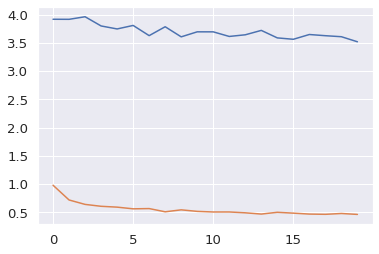

In [30]:
plt.plot(loss_g_per_epoch)
plt.plot(loss_d_per_epoch)
plt.show()

Decide to train model moreover 

In [17]:
torch.save(model_disc, '/kaggle/working/disc1.gan') #save model
torch.save(model_gen, '/kaggle/working/gen1.gan') #save model

In [5]:
model_gen = torch.load('/kaggle/input/generator-1/gen1.gan') #load model
model_disc = torch.load('/kaggle/input/discriminator/disc.gan') #load model

In [12]:
model_load = {
    "discriminator": model_disc.to(device),
    "generator": model_gen.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
history = fit(model_load, criterion, loader, epochs=40)

After training face generation better.

## Generate examples

In [12]:
n_images = 12

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model_gen(fixed_latent)

In [13]:
def show_images(generated): 

    fig = plt.figure()
    fake_img = make_grid(generated.detach().cpu(), normalize=True, nrow=6)
    plt.figure(figsize = (15, 15))
    plt.imshow(np.rollaxis(fake_img.numpy(), 0, 3))
    plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

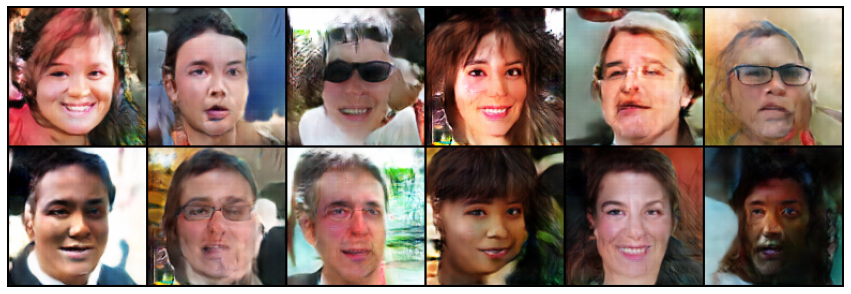

In [14]:
show_images(fake_images) #show generated images

## Leave-one-out-1-NN classifier accuracy

In [14]:
len_real_image = len(loader.dataset)

In [16]:
latent = torch.randn(len_real_image, latent_size, 1, 1, device=device)

In [ ]:
#Create fake images
latent = torch.randn(len_real_image, latent_size, 1, 1, device=device)
batch_size = 64
batches = len_real_image // batch_size

if not os.path.exists('/kaggle/working/fake_img/'):
    os.mkdir('/kaggle/working/fake_img/')
    
for i in range(batches+1):
    if i == batches:
        rang = (i*batch_size, len_real_image)
    else:
        rang = (i*batch_size, i*batch_size + batch_size)

    fake_images = model_gen(latent[rang[0]:rang[1]])
    for idx, img in enumerate(fake_images):
        save_image(img, f'/kaggle/working/fake_img/{rang[0]+idx}.png', normalize=True)

In [4]:
import shutil

In [ ]:
!zip -r fake.zip '/kaggle/working/fake_img/'

In [ ]:
shutil.rmtree('/kaggle/working')

Create arrays with 2000 images

In [3]:
fake_image = []
real_image = []
def create_image_arrays(len_array, amount):
    choice = np.random.randint(0, len_array, amount)
    list_real_files = os.listdir('/kaggle/input/flickrfaceshq-dataset-ffhq')
    list_fake_files = os.listdir('/kaggle/input/fake-img/working/fake_img')
    real_choosen = [list_real_files[i] for i in choice]
    fake_choosen = [list_fake_files[i] for i in choice]
    for real, fake in zip(real_choosen, fake_choosen):
        img_real = Image.open(f'/kaggle/input/flickrfaceshq-dataset-ffhq/{real}').resize((128, 128)) 
        img_fake = Image.open(f'/kaggle/input/fake-img/working/fake_img/{fake}').resize((128, 128))
        real_image.append(np.asarray(img_real)/255)
        fake_image.append(np.asarray(img_fake)/255)

In [4]:
create_image_arrays(52000, 4000)

In [5]:
fake_image = np.array(fake_image)
real_image = np.array(real_image)

In [6]:
real_targets = np.ones(len(real_image))
fake_targets = np.zeros(len(fake_image))

In [7]:
images = np.vstack((real_image, fake_image)).reshape(-1, 128*128*3)
targets = np.hstack((real_targets, fake_targets))

In [8]:
targets = np.expand_dims(targets, axis=1)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
loo = LeaveOneOut()
one_nn_accuracy = []
knn =  KNeighborsClassifier(n_neighbors=1)
for i, (train, test) in enumerate(loo.split(images)):
    if i%100 == 0:
        print(i)
    knn.fit(images[train], targets[train])
    one_nn_accuracy.append(targets[test].reshape(-1) - knn.predict(images[test])[0])

In [11]:
acc = 1 - np.array([x.item() for x in one_nn_accuracy]).sum()/len(one_nn_accuracy)
acc

0.92875

Accuracy equal 92.9%.

### Visualisation

Create arrays with 2000 images and reduce dimension --> 2 

In [38]:
fake_image = []
real_image = []
def create_image_arrays(len_array, amount):
    choice = np.random.randint(0, len_array, amount)
    list_real_files = os.listdir('/kaggle/input/flickrfaceshq-dataset-ffhq')
    list_fake_files = os.listdir('/kaggle/input/fake-img/working/fake_img')
    real_choosen = [list_real_files[i] for i in choice]
    fake_choosen = [list_fake_files[i] for i in choice]
    for real, fake in zip(real_choosen, fake_choosen):
        img_real = Image.open(f'/kaggle/input/flickrfaceshq-dataset-ffhq/{real}').resize((128, 128)) 
        img_fake = Image.open(f'/kaggle/input/fake-img/working/fake_img/{fake}').resize((128, 128))
        real_image.append(np.asarray(img_real).flatten()/255)
        fake_image.append(np.asarray(img_fake).flatten()/255)

In [39]:
create_image_arrays(52000, 2000)

In [ ]:
real_image_tsne = TSNE(2).fit_transform(real_image)
fake_image_tsne = TSNE(2).fit_transform(fake_image)

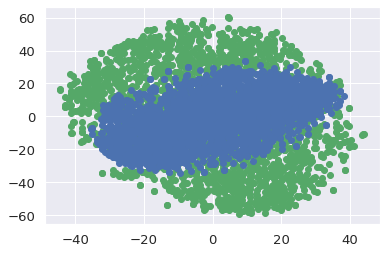

In [81]:
_, ax = plt.subplots()
ax.scatter(fake_image_tsne[:,0], fake_image_tsne[:,1], c=['g'])
ax.scatter(real_image_tsne[:,0], real_image_tsne[:,1], c='b')

Generated images more scattered on space 